# Introduction

This notebook is to demonstrate how the price of cryptocurrency can be predicted.<br>
We use five different timeseries prediction models. 

# Import Library

- pandas-data reader and yfinance is used to obtain datasets
- Darts is used to try several time-series prediction models.



In [ ]:
!pip -qqq install darts optuna yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.7 MB/s eta 0:

In [ ]:
import numpy as np
import pandas as pd
import darts
import optuna

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') 
plt.rcParams['figure.figsize'] = [12, 9] 

from pandas_datareader import data as pdr
import yfinance as yfin

# Obtaining Datasets

In [ ]:
import datetime

today = datetime.date.today()
yesterday = today - datetime.timedelta(days=1)
yesterday_5yearsback = yesterday - datetime.timedelta(days=365*5)

In [ ]:
yfin.pdr_override()

tickers = ['BTC', 'ETH', 'BNB', 'XRP', 'HEX', 'ADA', 'DOGE', 'SOL']

df_ind = pd.date_range(start=yesterday_5yearsback, periods=365*5, freq='D')
df = pd.DataFrame(columns=tickers, index=df_ind)

for ticker in tickers:
    data = pdr.get_data_yahoo(ticker+'-USD', start=yesterday_5yearsback, end=yesterday)
    df[ticker] = data['Adj Close']

df = df.dropna()
df.reset_index(inplace=True)
df['date'] = pd.to_datetime(df['index'])
df.drop('index', axis=1, inplace=True)

df.head(20)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-5-593913126dc6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['index'])
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,BTC,ETH,BNB,XRP,HEX,ADA,DOGE,SOL,date
0,6865.493164,158.412445,13.737724,0.187464,0.000425,0.033215,0.001968,0.951054,2020-04-10
1,6859.083008,158.216019,13.804288,0.188063,0.000496,0.033354,0.001990,0.776819,2020-04-11
2,6971.091797,161.142426,14.375111,0.190135,0.000572,0.033806,0.001990,0.882507,2020-04-12
3,6845.037598,156.279556,15.034427,0.187732,0.000506,0.033107,0.001959,0.777832,2020-04-13
4,6842.427734,157.596390,15.525076,0.185335,0.000549,0.032974,0.001964,0.661925,2020-04-14
5,6642.109863,153.286896,14.593927,0.181270,0.000536,0.031863,0.001940,0.646651,2020-04-15
6,7116.804199,172.157379,15.702730,0.190104,0.000560,0.034408,0.002028,0.690816,2020-04-16
7,7096.184570,171.638580,15.735083,0.190202,0.000659,0.034573,0.002013,0.660728,2020-04-17
8,7257.665039,186.914001,16.593172,0.194925,0.001087,0.036553,0.002061,0.681096,2020-04-18
9,7189.424805,181.614960,16.139933,0.190859,0.001545,0.035816,0.002058,0.606969,2020-04-19


# Visualizing the data

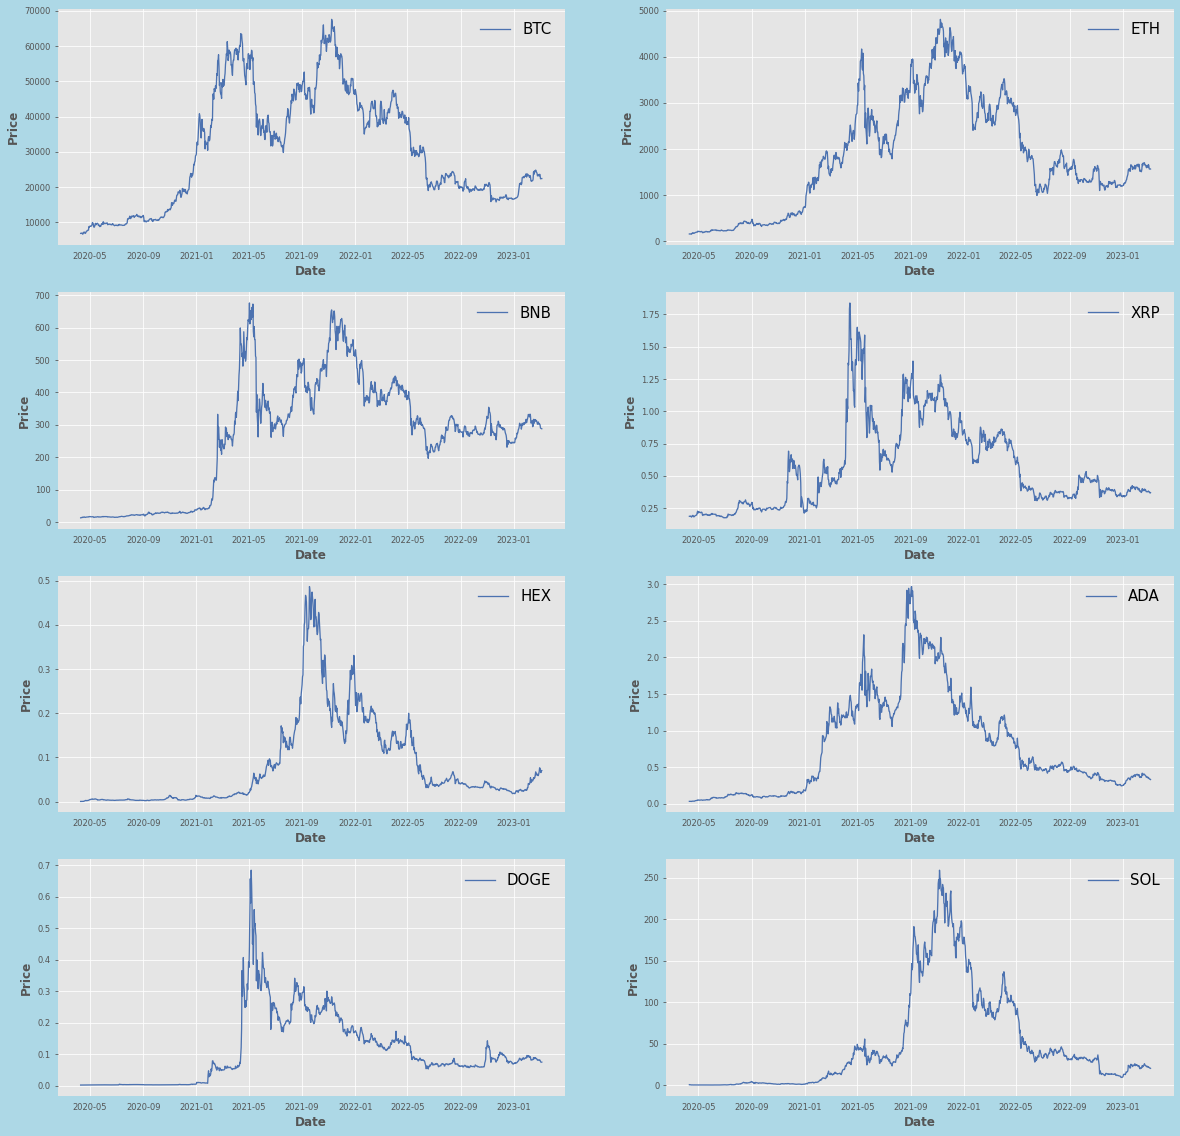

In [ ]:
fig = plt.figure(figsize = (20,20), facecolor='lightblue')

for i, ticker in enumerate(tickers): 
  ax = fig.add_subplot(4, 2, i+1)
  ax.plot(df['date'], df[ticker], color='b', label=ticker)

  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  ax.legend(loc = 'upper right', prop={'size': 15}) 
  
sns.set()

plt.show()
plt.close()

# Preprocessing the datasets
Dataframe is converted to Timeseries object for Darts Library<br>
Models predict log difference of price, not price directly

In [ ]:
from darts import TimeSeries as ts

series = ts.from_dataframe(df, "date", tickers)

# calculate log difference
series_ld = series.map(np.log).diff()


val_length = 30

train, val = series_ld[:-val_length], series_ld[-val_length:]

# Creating model, Prediction, and Evaluation

We predict only a price of Bitcoin for this demonstration purpose.

## ARIMA

In [ ]:
from darts.models.forecasting import arima
from darts.metrics import rmse

model_arima = arima.ARIMA()

potential_params = {
    'p': [0, 1, 2, 4, 6, 8, 10],
    'd' : range(0, 3),
    'q' : range(0, 3)
}

best_model_arima, best_params, best_score= model_arima.gridsearch(
    potential_params, 
    series=train[tickers[0]], 
    val_series = val[tickers[0]],
    metric = rmse
)

best_model_arima.fit(train[tickers[0]])

prediction_arima  = best_model_arima.predict(len(val), num_samples=1000)

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarima

RMSE = 0.0257%


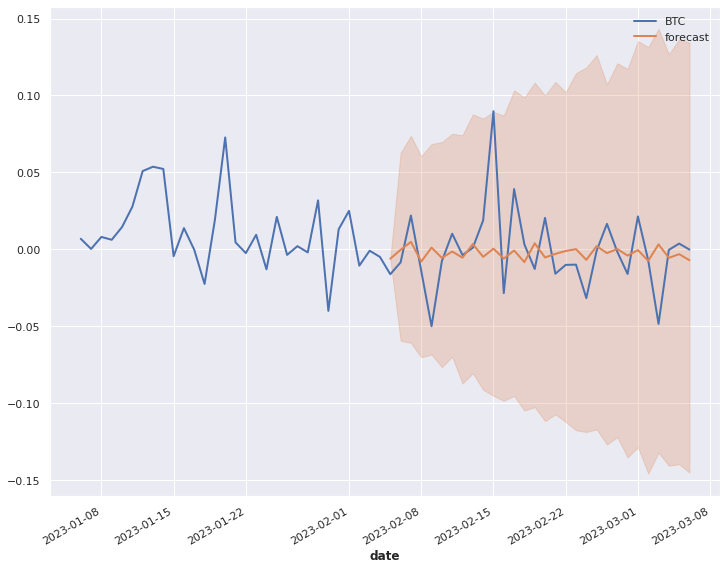

In [ ]:
from darts.metrics import rmse

print("RMSE = {:.4f}%".format(rmse(series_ld[tickers[0]] , prediction_arima)))

series_ld[tickers[0]][-val_length*2:].plot()
prediction_arima.plot(label="forecast")
plt.legend()

In [ ]:
prediction_arima_val = prediction_arima.map(lambda x: np.exp(np.add.accumulate(x)) * df.iat[-val_length, 0])

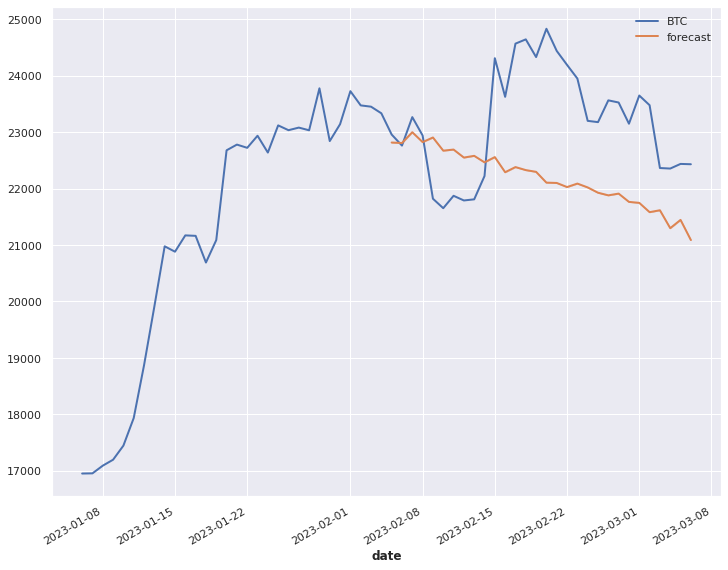

In [ ]:
series[tickers[0]][-val_length*2:].plot()
prediction_arima_val.plot(label="forecast", low_quantile=0.5, high_quantile=0.5)
plt.legend()

## Prophet

In [ ]:
from darts.models.forecasting import prophet_model

model_prop = prophet_model.Prophet()
model_prop.fit(train['BTC'])

prediction_prop  = model_prop.predict(len(val), num_samples=1000)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnekdsb2i/4sxxbbo9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnekdsb2i/k1wr51nx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=278', 'data', 'file=/tmp/tmpnekdsb2i/4sxxbbo9.json', 'init=/tmp/tmpnekdsb2i/k1wr51nx.json', 'output', 'file=/tmp/tmpnekdsb2i/prophet_modelzory4ndr/prophet_model-20230308204033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:40:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:40:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE = 0.0257%


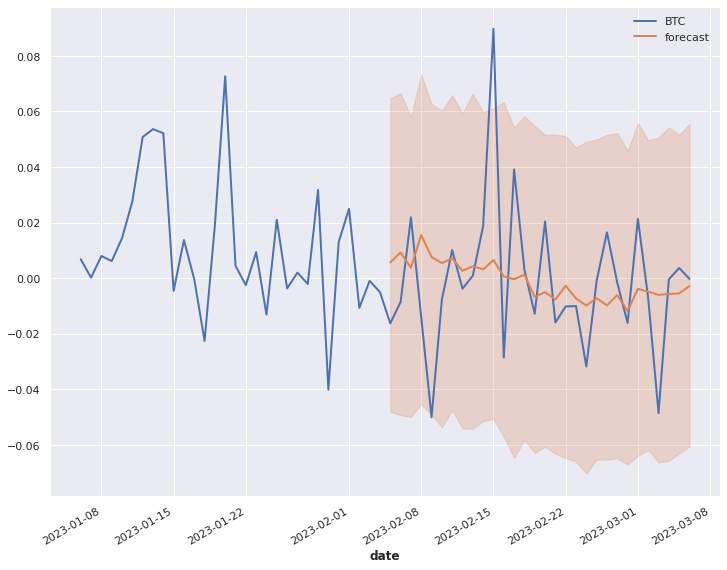

In [ ]:
print("RMSE = {:.4f}%".format(rmse(series_ld[tickers[0]] , prediction_prop)))

series_ld[tickers[0]][-val_length*2:].plot()
prediction_prop.plot(label="forecast")
plt.legend()

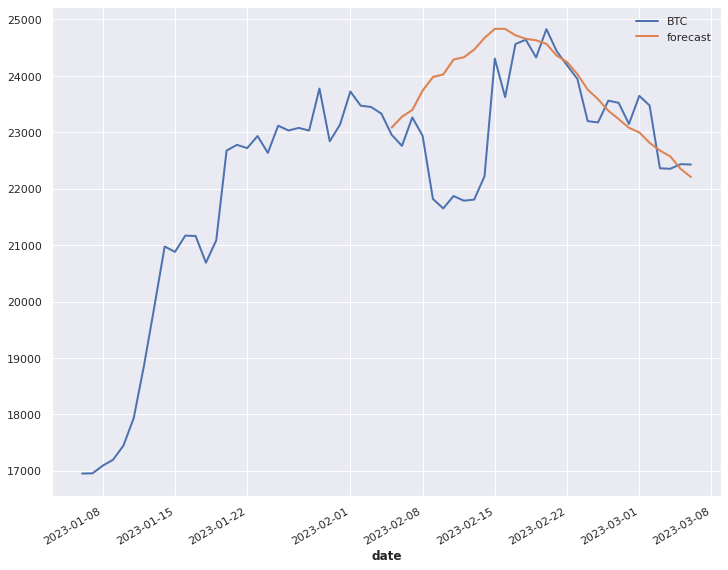

In [ ]:
prediction_prop_val = prediction_prop.map(lambda x: np.exp(np.add.accumulate(x)) * df.iat[-val_length, 0])

series[tickers[0]][-val_length*2:].plot()
prediction_prop_val.plot(label="forecast", low_quantile=0.5, high_quantile=0.5)
plt.legend()

## Kalman Filter

In [ ]:
from darts.models.forecasting import kalman_forecaster

model_kf = kalman_forecaster.KalmanForecaster()
model_kf.fit(train['BTC'])

prediction_kf  = model_kf.predict(len(val), num_samples=1000)

RMSE = 0.0259%


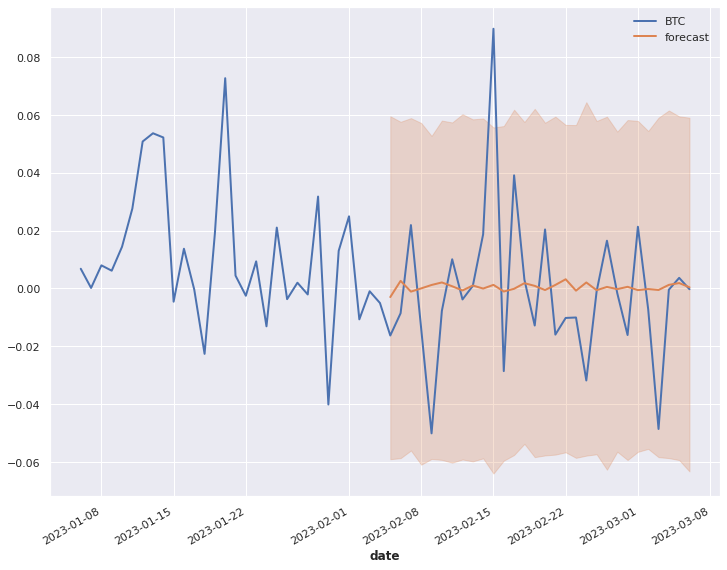

In [ ]:
print("RMSE = {:.4f}%".format(rmse(series_ld[tickers[0]] , prediction_kf)))

series_ld[tickers[0]][-val_length*2:].plot()
prediction_kf.plot(label="forecast")
plt.legend()

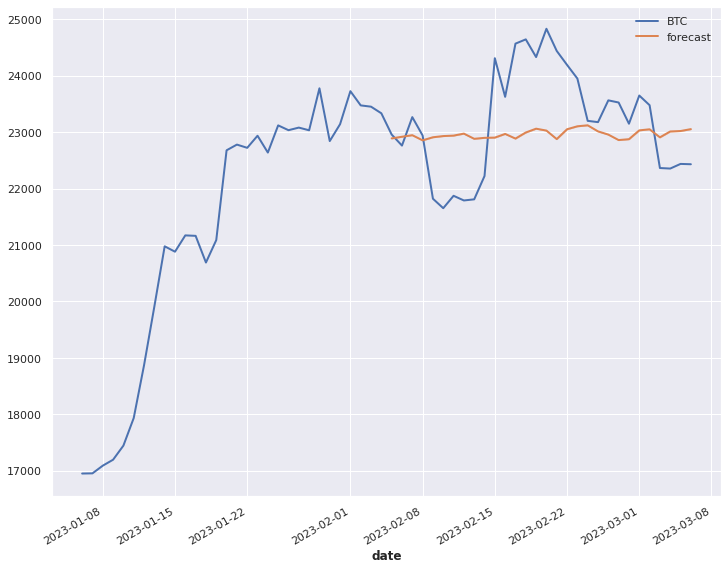

In [ ]:
prediction_kf_val = prediction_kf.map(lambda x: np.exp(np.add.accumulate(x)) * df.iat[-val_length, 0])

series[tickers[0]][-val_length*2:].plot()
prediction_kf_val.plot(label="forecast", low_quantile=0.5, high_quantile=0.5)
plt.legend()

## N-BEATS

In [ ]:
from darts.models.forecasting import nbeats
from darts.dataprocessing.transformers import Scaler

In [ ]:
scaler = Scaler()
series_ld_scaled = scaler.fit_transform(series_ld['BTC']).astype(np.float32)

train_scaled, val_scaled = series_ld_scaled[:-val_length], series_ld_scaled[-val_length:]

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import MeanSquaredError

# A TorchMetric or val_loss can be used as the monitor
torch_metrics = MeanSquaredError()

# Early stop callback
nbeats_stopper = EarlyStopping(
    monitor="train_MeanSquaredError",  # "val_loss",
    patience=50,
    min_delta=0.05,
    mode='min',
)

nbeats_pl_trainer_kwargs = {"callbacks": [nbeats_stopper]}

# Create the model
model_nbeats = nbeats.NBEATSModel(
    input_chunk_length=25,
    output_chunk_length=5,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    dropout=0.2,
    n_epochs=500,
    nr_epochs_val_period=1,
    batch_size=256,
    torch_metrics=torch_metrics,
    pl_trainer_kwargs=nbeats_pl_trainer_kwargs,
    random_state=42,
    model_name="nbeats_run"
)

model_nbeats.fit(train_scaled['BTC'], val_series=val_scaled['BTC'], verbose=True)



/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/lightning_fabric/accelerators/cuda.py:236: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.1 M 
--------------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('val_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
pred = model_nbeats.predict(n=30, num_samples=1000)

# scale back:
prediction_nbeats = scaler.inverse_transform(pred)
val = scaler.inverse_transform(val_scaled)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

RMSE = 0.0287%


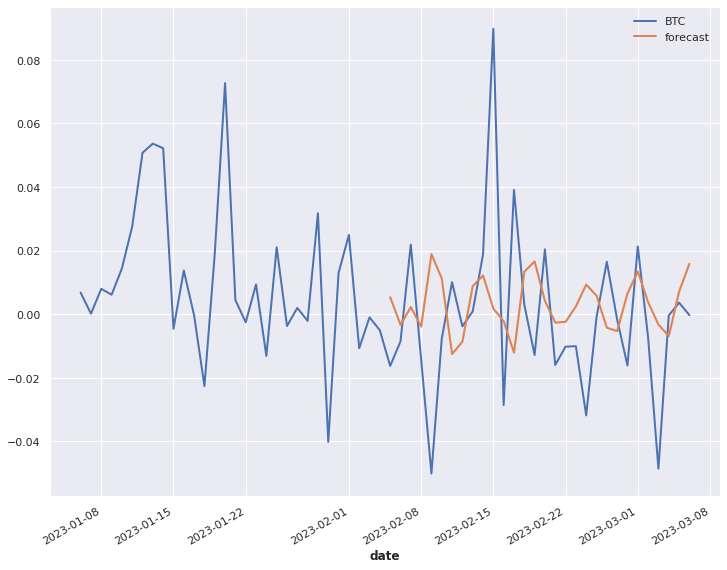

In [ ]:
print("RMSE = {:.4f}%".format(rmse(series_ld[tickers[0]] , prediction_nbeats)))

series_ld[tickers[0]][-val_length*2:].plot()
prediction_nbeats.plot(label="forecast")
plt.legend()

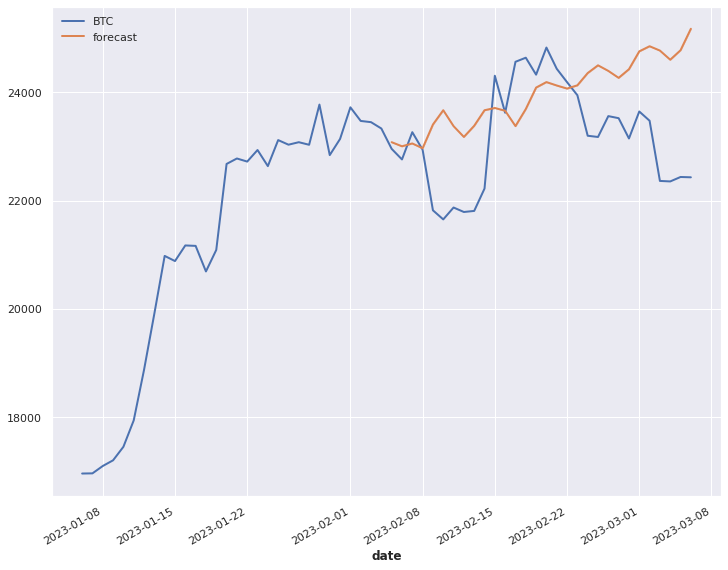

In [ ]:
prediction_nbeats_val = prediction_nbeats.map(lambda x: np.exp(np.add.accumulate(x)) * df.iat[-val_length, 0])

series[tickers[0]][-val_length*2:].plot()
prediction_nbeats_val.plot(label="forecast", low_quantile=0.5, high_quantile=0.5)
plt.legend()

## Temporal Fusion Transformer

In [ ]:
from darts.models.forecasting import tft_model

tft_stopper = EarlyStopping(
    monitor="train_MeanSquaredError",  # "val_loss",
    patience=50,
    min_delta=0.05,
    mode='min',
)

tft_pl_trainer_kwargs = {"callbacks": [tft_stopper]}

model_tft = tft_model.TFTModel(
    input_chunk_length=25,
    output_chunk_length=5,
    dropout=0.1,
    n_epochs=500,
    nr_epochs_val_period=1,
    batch_size=256,
    add_encoders={
    'datetime_attribute': {'future': ['dayofweek']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'transformer': Scaler()
    },
    torch_metrics=torch_metrics,
    pl_trainer_kwargs=tft_pl_trainer_kwargs,
    random_state=42,
    model_name="tft_run"
)

In [ ]:
model_tft.fit(train_scaled['BTC'], val_series=val_scaled['BTC'], verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
5  | decoder_vsn                       | _Vari

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('val_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
pred = model_tft.predict(n=30, num_samples=1000)

# scale back:
prediction_tft = scaler.inverse_transform(pred)
val_tft = scaler.inverse_transform(val_scaled)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

RMSE = 0.0287%


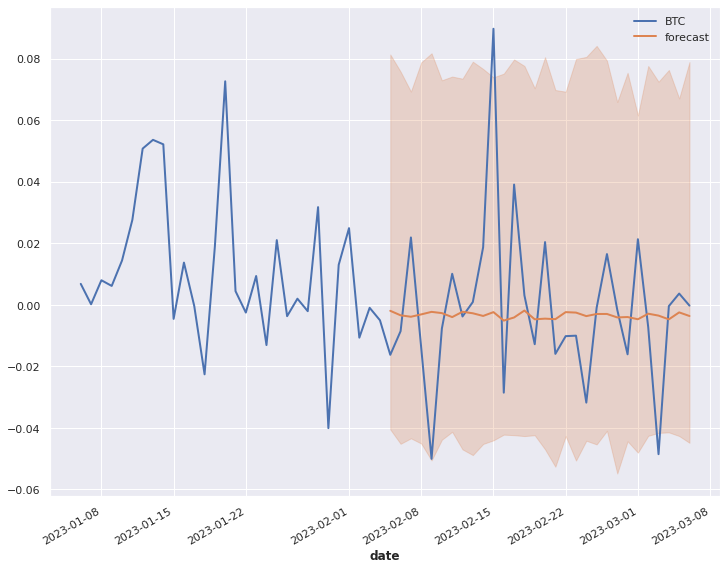

In [ ]:
print("RMSE = {:.4f}%".format(rmse(series_ld[tickers[0]] , prediction_nbeats)))

series_ld[tickers[0]][-val_length*2:].plot()
prediction_tft.plot(label="forecast")
plt.legend()

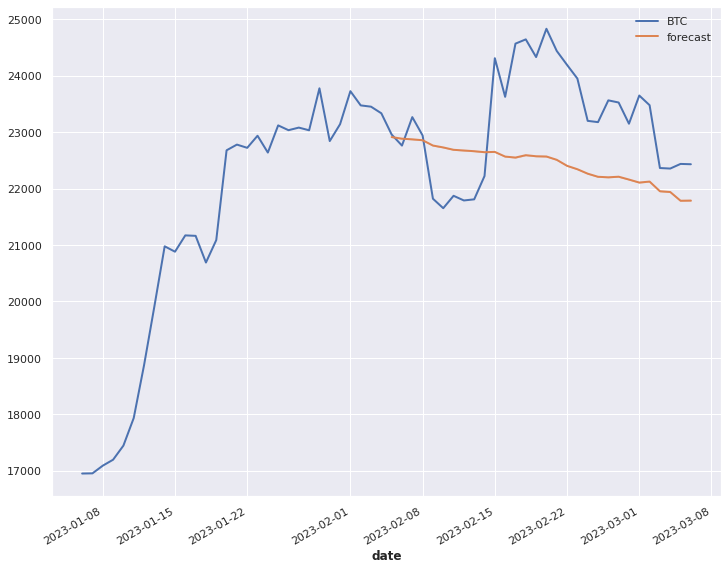

In [ ]:
prediction_tft_val = prediction_tft.map(lambda x: np.exp(np.add.accumulate(x)) * df.iat[-val_length, 0])

series[tickers[0]][-val_length*2:].plot()
prediction_tft_val.plot(label="forecast", low_quantile=0.5, high_quantile=0.5)
plt.legend()